In [1]:
# Gross code to allow for importing from parent directory
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

### Imports

In [2]:
import torch
import einops
import numpy as np

from jaxtyping import Float
from torch import Tensor

from transformer_lens import HookedTransformer
from load_data import get_prompts_t
from plotting import ntensor_to_long

from plotly.graph_objs.layout._shape import Shape
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set()


# Global settings and variables
torch.set_grad_enabled(False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [3]:
def reinforcement_ratio(
    cleaner_vectors: Float[Tensor, "... d_model"],
    writer_vectors: Float[Tensor, "... d_model"],
) -> Float[Tensor, "..."]:
    """
    Works element-wise on the last dimension of the input tensors.

    Interpretation: 
    After you project `cleaner_vectors` onto the direction of
    `writer_vectors`, the reinforcement ratio is the ratio of length of the
    projection to the length of `writer_vectors`.

    A reinforcement ratio of -1 means that the projection is in the opposite
    direction of `writer_vectors`, and has the same L2 norm.
    
    Mathematically:
    reinforcement_ratio(A, B) = (A⋅B) / ||B||^2
        OR
    reinforcement_ratio(A, B) = cos_sim(A, B) * ||A|| / ||B||


    Args:
        cleaner_vectors: a tensor of vectors that will be projected
        writer_vectors: a tensor of vectors that will be projected onto
    """
    return einops.einsum(
        cleaner_vectors,
        writer_vectors / writer_vectors.norm(dim=-1, keepdim=True).pow(2),
        "... d_model, ... d_model -> ...",
    )


def reinforcement_ratio_cartesian(
    cleaner_vectors: Float[Tensor, "dim0_arg0 ... d_model"],
    writer_vectors: Float[Tensor, "dim0_arg1 ... d_model"],
) -> Float[Tensor, "..."]:
    """
    Same as `reinforcement_ratio`, but takes the Cartesian product of the
    first dimension of the input tensors.
    """
    return einops.einsum(
        cleaner_vectors,
        writer_vectors / writer_vectors.norm(dim=-1, keepdim=True).pow(2),
        "dim0_arg0 ... d_model, dim0_arg1 ... d_model -> dim0_arg0 dim0_arg1 ...",
    )


def cos_sim(
    cleaner_vectors: Float[Tensor, "... d_model"],
    writer_vectors: Float[Tensor, "... d_model"],
) -> Float[Tensor, "..."]:
    """
    Works element-wise on the last dimension of the input tensors.

    Mathematically: cos_sim(A, B) = (A•B) / (||A|| * ||B||)
    """
    return einops.einsum(
        cleaner_vectors / cleaner_vectors.norm(dim=-1, keepdim=True),
        writer_vectors / writer_vectors.norm(dim=-1, keepdim=True),
        "... d_model, ... d_model -> ...",
    )


def cos_sim_cartesian(
    cleaner_vectors: Float[Tensor, "dim0_arg0 ... d_model"],
    writer_vectors: Float[Tensor, "dim0_arg1 ... d_model"],
) -> Float[Tensor, "..."]:
    """
    Works element-wise on the last dimension of the input tensors.

    Mathematically: cos_sim(A, B) = (A•B) / (||A|| * ||B||)
    """
    return einops.einsum(
        cleaner_vectors / cleaner_vectors.norm(dim=-1, keepdim=True),
        writer_vectors / writer_vectors.norm(dim=-1, keepdim=True),
        "dim0_arg0 ... d_model, dim0_arg1 ... d_model -> dim0_arg0 dim0_arg1 ...",
    )

In [4]:
prompts = get_prompts_t()
# prompts = get_prompts_t(n_text_prompts=160, n_code_prompts=40)

# Throws a warning if there is a non-unique prompt
if not (torch.unique(prompts, dim=0).shape == prompts.shape):
    print("WARNING: at least 1 prompt is not unique")

Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
#Transformer Lens model names:
# https://github.com/neelnanda-io/TransformerLens/blob/3cd943628b5c415585c8ef100f65989f6adc7f75/transformer_lens/loading_from_pretrained.py#L127

model_name = "gelu-4l"
model = HookedTransformer.from_pretrained(model_name, device=device)
model.cfg.use_attn_result = True

Loaded pretrained model gelu-4l into HookedTransformer


In [6]:
# Generate names of residual stream components
resid_names = ["blocks.0.hook_resid_pre"]
for i in range(model.cfg.n_layers):
    resid_names.append(f"blocks.{i}.hook_resid_mid")
    resid_names.append(f"blocks.{i}.hook_resid_post")

# Generate names of attention blocks for each layer
attn_names = []
for i in range(model.cfg.n_layers):
    attn_names.append(f"blocks.{i}.attn.hook_result")

# Generate names of MLP out for each layer
mlp_names = []
for i in range(model.cfg.n_layers):
    mlp_names.append(f"blocks.{i}.hook_mlp_out")

hook_names = resid_names + attn_names + mlp_names

In [7]:
# Run a forward pass and cache selected activations
_, cache = model.run_with_cache(
    prompts[:30],
    names_filter=lambda name: name in hook_names,
    device=device,
)

In [8]:
# Concatenate the cached activations into tensors
cache_resids = torch.stack(
    [cache[name] for name in resid_names],
    dim=0,
)  # shape: (resid, batch, pos, d_model)

# Generate node names by layer
node_names = []
for l in range(model.cfg.n_layers):
    node_names.extend([f"H{l}.{h}" for h in range(model.cfg.n_heads)])
    node_names.append(f"MLP_{l}")

# Generate node tensors by layer, where the node dimension aligns with `node_names`
node_tensors = []
for l in range(model.cfg.n_layers):
    attn_heads_of_layer = cache[f"blocks.{l}.attn.hook_result"]
    attn_heads_of_layer = einops.rearrange(
        attn_heads_of_layer, "batch pos head d_model -> head batch pos d_model",
    )
    mlp_of_layer = cache[f"blocks.{l}.hook_mlp_out"].unsqueeze(0)
    node_tensors.append(torch.cat([attn_heads_of_layer, mlp_of_layer], dim=0))

cache_nodes = torch.cat(node_tensors, dim=0)  # shape: (node, batch, pos, d_model)

assert cache_nodes.ndim == cache_resids.ndim

In [9]:
# Calculate reinforcement ratios
reinf_ratios = reinforcement_ratio_cartesian(cache_resids, cache_nodes)  # shape: (resid node batch pos)

In [10]:
df = ntensor_to_long(
    reinf_ratios,
    value_name="reinforcement_ratio",
    dim_names=["resid", "node", "batch", "pos"],
)

layers, comps = divmod(df.node, model.cfg.n_heads + 1)
df["layer"] = layers
df["comp"] = comps

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953280 entries, 0 to 9953279
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   reinforcement_ratio  float32
 1   resid                int64  
 2   node                 int64  
 3   batch                int64  
 4   pos                  int64  
 5   layer                int64  
 6   comp                 int64  
dtypes: float32(1), int64(6)
memory usage: 493.6 MB


In [11]:
quantile_fncs = [
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.50),
    lambda x: x.quantile(0.75),
]

df_quantiles = (
    df.groupby(["resid", "layer", "comp"])
    .agg({"reinforcement_ratio": quantile_fncs})
)
df_quantiles.columns = ["rr_q25", "rr_q50", "rr_q75"]
df_quantiles = df_quantiles.reset_index()

df_quantiles["error_plus"] = df_quantiles.rr_q75 - df_quantiles.rr_q50
df_quantiles["error_minus"] = df_quantiles.rr_q50 - df_quantiles.rr_q25

# Set component names
df_quantiles["comp_name"] = "H" + df_quantiles.layer.astype(str) + "." + df_quantiles.comp.astype(str)
df_quantiles["comp_name"] = df_quantiles.comp_name.where(
    df_quantiles.comp != model.cfg.n_heads,
    "MLP" + df_quantiles.layer.astype(str),
)

In [104]:
# Create main figure
main_fig = go.Figure()

# Add all traces to main figure
for l in range(model.cfg.n_layers):
    tmp_fig = px.line(
        data_frame=df_quantiles.query(f"layer == {l}"),
        x="resid",
        y="rr_q50",
        color="comp_name",
        error_y="error_plus",
        error_y_minus="error_minus",
    )

    for trace in tmp_fig.select_traces():
        main_fig.add_trace(trace)

# Set title on start
title = (
    f"Various residual stream locations, projected onto the outputs of "
    f"components in layer 0"
)
main_fig.update_layout(title={"text": title}
)
main_fig.add_vline(x=0.5, line_dash="dash", line_color="grey")
main_fig.add_vline(x=1.5, line_dash="dot", line_color="grey")

# Which traces to show on start
layers_to_show = np.zeros(model.cfg.n_layers, dtype=bool)
layers_to_show[0] = True
traces_to_show = np.repeat(layers_to_show, model.cfg.n_heads + 1)

for data, to_show in zip(main_fig.data, traces_to_show):
    data.visible = to_show

# Create and add slider
slider_steps = []
for i in range(model.cfg.n_layers):
    # Which traces to show on slider update
    layers_to_show = np.zeros(model.cfg.n_layers, dtype=bool)
    layers_to_show[i] = True
    traces_to_show = np.repeat(layers_to_show, model.cfg.n_heads + 1)

    title = (
        f"Various residual stream locations, projected onto the outputs of "
        f"components in layer {i}"
    )

    shapes = []
    for j, style in zip([0, 1], ["dash", "dot"]):
        shapes.append(Shape({
            'line': {'color': 'grey', 'dash': style},
            'type': 'line',
            'x0': 0.5 + i*2 + j,
            'x1': 0.5 + i*2 + j,
            'xref': 'x',
            'y0': 0,
            'y1': 1,
            'yref': 'y domain'
        }))

    step = dict(
        method="update",
        label=f"Layer {i}",
        args=[
            {"visible": traces_to_show},
            {"title": title},
            {"shapes": shapes}
        ],  # Layout attributes
    )

    step["args"][1]["shapes"] = shapes

    slider_steps.append(step)

sliders = [dict(
    active=0,
    steps=slider_steps,
)]

# Prep main figure
middle_ticks = []
for l in range(model.cfg.n_layers):
    middle_ticks.append(f"H{l}.X")
    middle_ticks.append(f"MLP{l}")
xaxis_ticknames = [val for pair in zip(resid_names, middle_ticks) for val in pair] + [resid_names[-1]]

main_fig.update_layout(
    sliders=sliders,
    xaxis_title="Residual Stream Location",
    yaxis_title="Reinforcement Ratio",
    xaxis=dict(
        tickmode="array",
        tickvals=np.arange(0, model.cfg.n_heads + 0.1, 0.5),
        ticktext=xaxis_ticknames,
    ),
    height=600,
)
# Reposition the slider
main_fig["layout"]["sliders"][0]["pad"] = dict(t=120)

### Projecting Residual Stream Onto Nodes

In [105]:
main_fig.show()

In [14]:
# Projection heads in layer 2 onto H0.2
layer2_heads = cache["blocks.2.attn.hook_result"]
layer2_heads = einops.rearrange(
    layer2_heads, "batch pos head d_model -> head batch pos d_model"
)

H0_2 = cache["blocks.0.attn.hook_result"][:, :, 2, :]

rrs_layer2_heads_onto_H0_2 = reinforcement_ratio(layer2_heads, H0_2)

In [15]:
df2 = ntensor_to_long(
    rrs_layer2_heads_onto_H0_2,
    value_name="reinforcement_ratio",
    dim_names=["L2_head", "batch", "pos"],
)

<Axes: xlabel='L2_head', ylabel='reinforcement_ratio'>

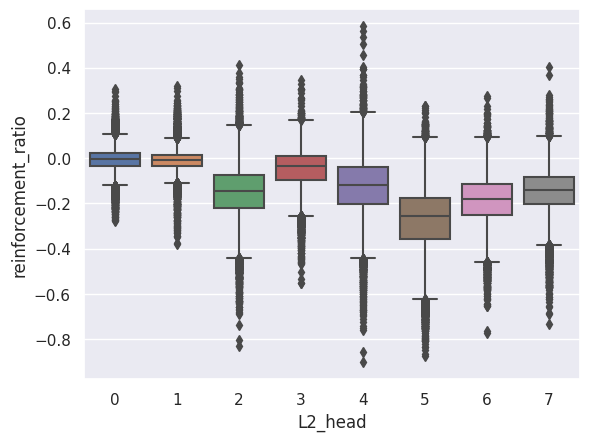

In [16]:
sns.boxplot(
    data=df2,
    x="L2_head",
    y="reinforcement_ratio",
)

### Projecting Attn Heads in Layer 2 onto H0.2

<Axes: xlabel='L2_head', ylabel='reinforcement_ratio'>

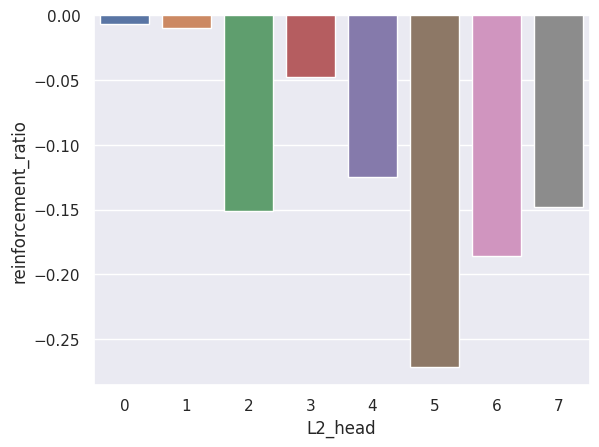

In [17]:
sns.barplot(
    data=df2.groupby("L2_head").mean().reset_index(),
    x="L2_head",
    y="reinforcement_ratio",
)

In [18]:
df2.groupby("L2_head")[["reinforcement_ratio"]].mean()

,reinforcement_ratio
L2_head,
0,-0.006382
1,-0.009472
2,-0.150954
3,-0.047534
4,-0.124790
5,-0.271807
6,-0.185894
7,-0.148035


In [19]:
df2.groupby("L2_head")[["reinforcement_ratio"]].mean().sum()

reinforcement_ratio   -0.944866
dtype: float32

In [20]:
L2_cos_sims = cos_sim_cartesian(layer2_heads, layer2_heads)
L2_cos_sims.shape

torch.Size([8, 8, 30, 1024])

In [21]:
cos_sim_matrix = einops.reduce(L2_cos_sims, "h1 h2 batch pos -> h1 h2", "mean")
cos_sim_matrix.fill_diagonal_(torch.tensor(0));

### Pairwise Cos Sims of Attn Heads in Layer 2

In [22]:
title = (
    "Pairwise cosine similarity of layer 2 attention heads<br>"
    "Mean across batch (n=200) and position dimensions<br>"
    "(Diagonal elements are set to 0)"
)

absmax = cos_sim_matrix.abs().max().item()

px.imshow(
    cos_sim_matrix,
    color_continuous_scale="RdBu",
    range_color=[-absmax, absmax],
    title=title,
    width=600,
)

In [23]:
import psutil
psutil.virtual_memory()

svmem(total=211076595712, available=188559192064, percent=10.7, used=20795703296, free=187701760000, active=1403703296, inactive=20905820160, buffers=115204096, cached=2463928320, shared=16007168, slab=492720128)